<a href="https://colab.research.google.com/github/salmanbhatti87/CodeSoft/blob/main/Resnet25_without_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os

In [2]:
# Load the dataset from TensorFlow
dataset_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=dataset_url, extract=True)
dataset_dir = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'validation')


68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
import tensorflow as tf
import os

dataset_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
path_to_zip = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=dataset_url, extract=True)

dataset_dir = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

# Verify dataset structure
print("Dataset directory exists:", os.path.exists(dataset_dir))
print("Subdirectories:", os.listdir(dataset_dir) if os.path.exists(dataset_dir) else "Not found")

train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'validation')

print("Train directory exists:", os.path.exists(train_dir))
print("Validation directory exists:", os.path.exists(val_dir))

68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Dataset directory exists: False
Subdirectories: Not found
Train directory exists: False
Validation directory exists: False


In [4]:
import os
import tensorflow as tf

# Get the default storage path for datasets
dataset_path = tf.keras.utils.get_file(
    'cats_and_dogs_filtered.zip',
    origin="https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
)

print("Downloaded file path:", dataset_path)


Downloaded file path: /root/.keras/datasets/cats_and_dogs_filtered.zip


In [5]:
import zipfile
import os

# Path to the downloaded ZIP file
dataset_zip_path = "/root/.keras/datasets/cats_and_dogs_filtered.zip"

# Extract it in the same directory
extract_path = os.path.dirname(dataset_zip_path)

with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verify extraction
extracted_dir = os.path.join(extract_path, "cats_and_dogs_filtered")
print("Dataset directory exists:", os.path.exists(extracted_dir))
print("Contents:", os.listdir(extracted_dir) if os.path.exists(extracted_dir) else "Extraction failed")

Dataset directory exists: True
Contents: ['validation', 'train', 'vectorize.py']


In [8]:
# Image Data Generators (without augmentation)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1.0/255)

# Load train and validation data
train_data = train_datagen.flow_from_directory(
    train_dir, target_size=(128, 128), batch_size=32, class_mode='binary'
)

validation_data = validation_datagen.flow_from_directory(
    val_dir, target_size=(128, 128), batch_size=32, class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [9]:
 # Class names
class_names = list(train_data.class_indices.keys())
print("Class names:", class_names)

Class names: ['cats', 'dogs']


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Residual Block with adjustment for shape mismatch
def residual_block(x, filters, kernel_size=3, strides=1):
    shortcut = x  # Save the input for the skip connection

    # If downsampling (strides > 1), apply a 1x1 convolution to match dimensions
    if strides != 1:
        shortcut = Conv2D(filters, (1, 1), strides=strides, padding="same")(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # First convolution
    x = Conv2D(filters, kernel_size, strides=strides, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # Second convolution
    x = Conv2D(filters, kernel_size, strides=1, padding="same")(x)
    x = BatchNormalization()(x)

    # Skip connection (Add input to output)
    x = Add()([x, shortcut])
    x = Activation("relu")(x)

    return x

# Function to create ResNet-25 model
def create_resnet25(input_shape=(128, 128, 3)):
    inputs = Input(shape=input_shape)

    # Initial Conv Layer
    x = Conv2D(64, (7, 7), strides=2, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # Residual Blocks (Total: 25 layers)
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 128, strides=2)  # Downsampling
    x = residual_block(x, 128)
    x = residual_block(x, 256, strides=2)  # Downsampling
    x = residual_block(x, 256)
    x = residual_block(x, 512, strides=2)  # Downsampling
    x = residual_block(x, 512)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(1, activation="sigmoid")(x)  # Binary classification

    # Create model
    model = Model(inputs, outputs)
    return model

# Create and compile the model
model = create_resnet25()
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

# Model Summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 64, 64, 64)     │          9,472 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_27    │ (None, 64, 64, 64)     │            256 │ conv2d_27[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_23             │ (None, 64, 64, 64)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 64, 64, 64)     │         36,928 │ activation_23[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_28    │ (None, 64, 64, 64)     │            256 │ conv2d_28[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_24             │ (None, 64, 64, 64)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_29 (Conv2D)        │ (None, 64, 64, 64)     │         36,928 │ activation_24[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_29    │ (None, 64, 64, 64)     │            256 │ conv2d_29[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_11 (Add)              │ (None, 64, 64, 64)     │              0 │ batch_normalization_2… │
│                           │                        │                │ activation_23[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_25             │ (None, 64, 64, 64)     │              0 │ add_11[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 64, 64, 64)     │         36,928 │ activation_25[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_30    │ (None, 64, 64, 64)     │            256 │ conv2d_30[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_26             │ (None, 64, 64, 64)     │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_31 (Conv2D)   

 Total params: 11,191,425 (42.69 MB)

 Trainable params: 11,181,825 (42.66 MB)

 Non-trainable params: 9,600 (37.50 KB)

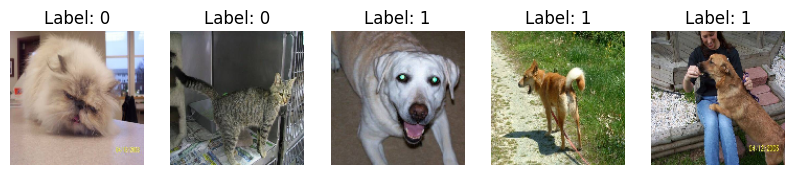

In [11]:
# Get one batch of images and labels
images, labels = next(train_data)

# Plot first 5 images
plt.figure(figsize=(10,5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(f"Label: {int(labels[i])}")
plt.show()

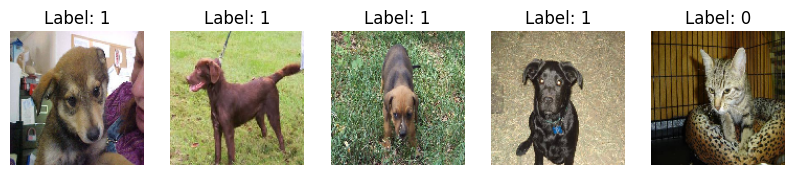

In [12]:
# Get one batch of images and labels
images, labels = next(validation_data)

# Plot first 5 images
plt.figure(figsize=(10,5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(f"Label: {int(labels[i])}")
plt.show()

In [ ]:
# Train the model
history = model.fit(
    train_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    epochs=35,
    validation_data=validation_data,
    validation_steps=validation_data.samples // validation_data.batch_size
)

Epoch 1/35


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 35s 271ms/step - accuracy: 0.5535 - loss: 0.8321 - val_accuracy: 0.5010 - val_loss: 0.7679
Epoch 2/35
 1/62 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.6250 - loss: 0.7070

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6250 - loss: 0.7070 - val_accuracy: 0.5010 - val_loss: 0.7615
Epoch 3/35
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 142ms/step - accuracy: 0.7238 - loss: 0.5565 - val_accuracy: 0.5010 - val_loss: 0.9877
Epoch 4/35
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8750 - loss: 0.4090 - val_accuracy: 0.5000 - val_loss: 0.9148
Epoch 5/35
62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 145ms/step - accuracy: 0.8312 - loss: 0.3999 - val_accuracy: 0.5000 - val_loss: 1.4732
Epoch 6/35
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7188 - loss: 0.7879 - val_accuracy: 0.4990 - val_loss: 1.5553
Epoch 7/35
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.8887 - loss: 0.2732 - val_accuracy: 0.5020 - val_loss: 1.6812
Epoch 8/35
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9375 - loss: 0.2024 - val_accuracy: 0.4980 - val_loss: 1.7496
Epoch 9/35
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 142ms/step - accuracy: 0.9543 - loss: 0.1323 - val_accuracy: 0.4970 - val_

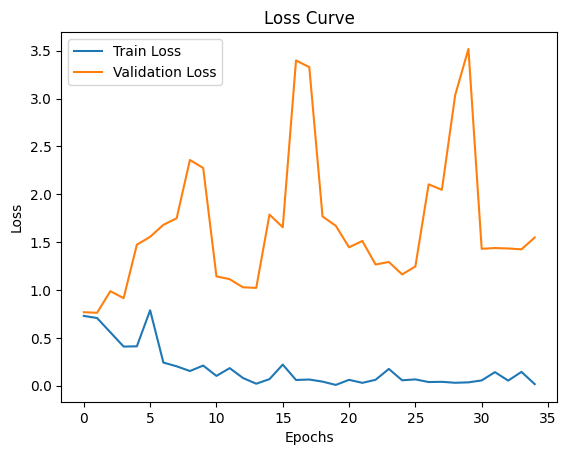

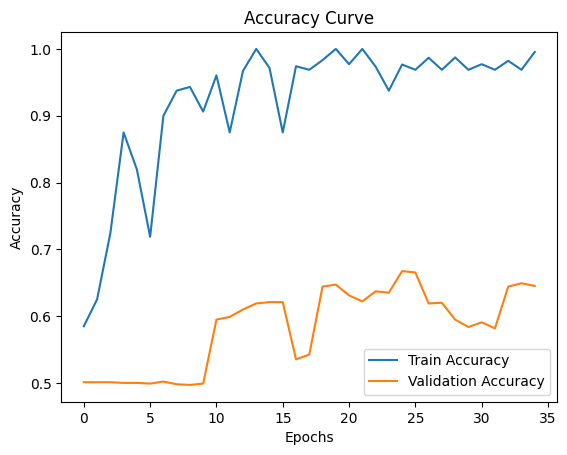

In [ ]:
# Plotting the loss and accuracy curves
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# Evaluate the model with classification metrics
y_true = validation_data.classes
y_pred = model.predict(validation_data)
y_pred = np.round(y_pred)  # Convert predictions to binary (0 or 1)

# Classification report and confusion matrix
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step
              precision    recall  f1-score   support

           0       0.48      0.36      0.41       500
           1       0.48      0.60      0.54       500

    accuracy                           0.48      1000
   macro avg       0.48      0.48      0.47      1000
weighted avg       0.48      0.48      0.47      1000

[[182 318]
 [201 299]]


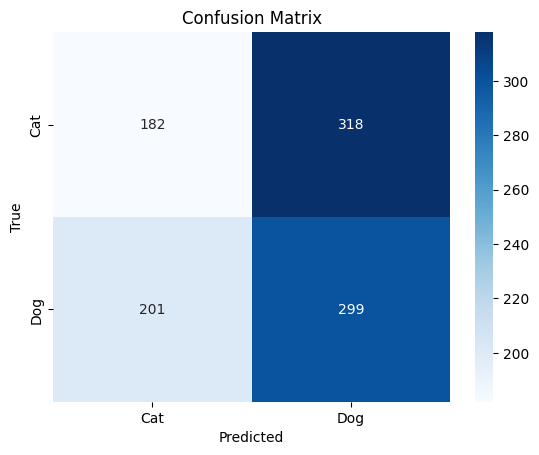

In [ ]:
# Plotting the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Cat", "Dog"], yticklabels=["Cat", "Dog"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()